In [5]:
import datetime
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import Dict, List, Optional, Tuple, Union

import pycountry
import networkx as nx

from pylab import colorbar
from pylab import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from bigbang.analysis.listserv import ListservMailList
#from bigbang.bigbang_io import pandas_dataframe_to_mbox
from bigbang.visualisation import graphs
from bigbang.datasets import organizations

from tgpp.config.config import CONFIG
import tgpp.ingress.queries as Queries
from tgpp.ingress import organizations as ORGA

plt.style.use("./publication_jcap.mplstyle")

## Load data

In [2]:
category_abbr_dict = {
    'Advertising company': 'Advertising company',
    'Chipmaker': 'Chipmaker',
    'Civil Society Organization': 'Civil Society Organization',
    'Cloud Provider': 'Cloud Provider',
    'Consulting': 'Consulting',
    'Consumer hardware and software vendor': 'Consumer hardware and\n software vendor',
    'Content Distribution Network': 'Content Distribution\n Network',
    'Content Provider': 'Content Provider',
    'Cybersecurity': 'Cybersecurity',
    'Database Provider': 'Database Provider',
    'Financial Institution': 'Financial Institution',
    'Hackerspace': 'Hackerspace',
    'Hardware Developer': 'Hardware Developer',
    'Hardware Provider': 'Hardware Provider',
    'IETF secretariat': 'IETF Secretariat',
    'Infrastructure Company': 'Infrastructure Company',
    'Internet Governance Body': 'Internet Governance Body',
    'Internet Registry': 'Internet Registry',
    'Law Enforcement Agency': 'Law Enforcement Agency',
    'Networking equipment vendor': 'Networking Equipment Vendor',
    'Networking Service Provider': 'Networking Service Provider',
    'Real time video': 'Real Time Video',
    'Regional Standards Body': 'Regional Standards Body',
    'Regulatory Body': 'Regulatory Body',
    'Research Institution': 'Research Institution',
    'Satellite Communications Provider': 'Satellite Communications Provider',
    'Software Provider': 'Software Provider',
    'Software Developer': 'Software Developer',
    'Space Agency': 'Space Agency',
    'Standards Body': 'Standards Body',
    'Technology research and development company': 'Technology Research and\n Development Company',
    'Telecommunications Provider': 'Telecommunications Provider',
    'Testing and Certification': 'Testing and Certification',
    'Public Finances and Economic Policy': 'Public Finances and\n Economic Policy',
    'Defence Agency': 'Defence Agency',
}

country_abbr_dict = {
    'Australia': 'AUS',
    'Austria': 'AUT',
    'Belgium': 'BEL',
    'Brazil': 'BRA',
    'Canada': 'CAN',
    'China': 'CHN',
    'Czech Republic': 'CZE',
    'Denmark': 'DNK',
    'Dominica': 'DMA',
    'Finland': 'FIN',
    'France': 'FRA',
    'Germany': 'DEU',
    'Ghana': 'GHA',
    'Greece': 'GRC',
    'Hong Kong': 'HKG',
    'India': 'IND',
    'Indonesia': 'IDN',
    'Ireland': 'IRL',
    'Italy': 'ITA',
    'Japan': 'JPN',
    'Republic of Korea': 'ROK',
    'Madagascar': 'MDG',
    'Mauritius': 'MUS',
    'Netherlands': 'NLD',
    'Norway': 'NOR',
    'Poland': 'POL',
    'Russian Federation': 'RUS',
    'Slovenia': 'SVN',
    'Spain': 'ESP',
    'Sweden': 'SWE',
    'Switzerland': 'CHE',
    'Taiwan': 'TWN',
    'United Arab Emirates': 'ARE',
    'United Kingdom': 'GBR',
    'United States': 'USA',
}

In [3]:
# Load data on organisations in 3GPP

df_orgcat = ORGA.load_data()
df_orgcat = ORGA.expand_rows_with_multiple_entries(df_orgcat, column='email domain names')
df_orgcat = ORGA.assign_parent_nationality(df_orgcat)
df_orgcat = ORGA.remove_leading_and_trailing_whitespaces(df_orgcat)

# choose columns of interest
df_nation = df_orgcat[[
    "full name",
    "nationality",
    "email domain names",
]]
# filter out all non-empty cells
df_nation = df_nation.dropna()
# use abbriviation for the figures
df_nation["nationality"] = df_nation["nationality"].apply(lambda x: country_abbr_dict[x])

# choose columns of interest
df_seccat = df_orgcat[[
    "full name",
    "category",
    "email domain names",
]]
# filter out all non-empty cells
df_seccat = df_seccat.dropna(subset=["category", "email domain names"])
df_seccat = ORGA.expand_rows_with_multiple_entries(df_seccat, column='category')
# use abbriviation for the figures
df_seccat["category"] = df_seccat["category"].apply(lambda x: category_abbr_dict[x])

In [4]:
# Load Search-set (Sset)
mlist_name = "3GPP_TSG_SA_WG3_LI"

sset_mlist = ListservMailList.from_mbox(
    name=mlist_name,
    filepath=CONFIG.folder_search_set + f"{mlist_name}.mbox",
)
init_sset_mlist_len = len(sset_mlist)
print(init_sset_mlist_len)

# only keep rows that have the header field 'from'
sset_mlist.df = sset_mlist.df.dropna(subset=['from'])

# only keep rows that have the header field 'date'
#mlist.df = mlist.df.dropna(subset=['date'])

sset_mlist.df['date'] = pd.to_datetime(sset_mlist.df['date'], format="%a, %d %b %Y %H:%M:%S %z", errors="coerce")
print(len(sset_mlist))

year_of_first_msg = np.min(sset_mlist.period_of_activity()).year
year_of_last_msg = np.max(sset_mlist.period_of_activity()).year

6419
6415


In [5]:
domains = sset_mlist.get_domains(header_fields=["from", "comments-to"])
len(np.unique(domains["from"] + domains["comments-to"]))

158

In [6]:
print(
    "S-set:",
    np.min(sset_mlist.period_of_activity()),
    np.max(sset_mlist.period_of_activity()),
)

S-set: 2000-09-06 06:45:22-07:00 2022-02-26 14:29:06+00:00


In [7]:
# Load Target-set

mlist_name = "3GPP_TSG_SA_WG3_LI"

# load target-set (Tset)
tset_df = pd.read_hdf(
    CONFIG.folder_target_set + f"{mlist_name}.h5",
    key="df",
    header=0,
    index_col=0,
)

non_query_columns = [col for col in tset_df.columns if col.startswith('msg-')]
tset_df = tset_df.loc[:, tset_df.columns.isin(non_query_columns)]
relable = {col: col.replace('msg-', '') for col in tset_df.columns}
tset_df = tset_df.rename(columns=relable, errors="raise")

tset_mlist = ListservMailList.from_pandas_dataframe(
    df=tset_df,
    name=mlist_name,
    filepath=CONFIG.folder_target_set + f"{mlist_name}.h5",
)
init_tset_mlist_len = len(tset_mlist)
print(init_tset_mlist_len)

# only keep rows that have the header field 'from'
tset_mlist.df = tset_mlist.df.dropna(subset=['from'])

# only keep rows that have the header field 'date'
#tset_mlist.df = tset_mlist.df.dropna(subset=['date'])

tset_mlist.df['date'] = pd.to_datetime(
    tset_mlist.df['date'],
    format="%a, %d %b %Y %H:%M:%S %z",
    errors="coerce",
)
print(len(tset_mlist))

year_of_first_msg = np.min(tset_mlist.period_of_activity()).year
year_of_last_msg = np.max(tset_mlist.period_of_activity()).year

3177
3177


In [8]:
print(
    "T-set:",
    np.min(sset_mlist.period_of_activity()),
    np.max(sset_mlist.period_of_activity()),
)

T-set: 2000-09-06 06:45:22-07:00 2022-02-26 14:29:06+00:00


In [9]:
# Select to analyse T-set or S-set
set_lable = 'tset'
mlist = tset_mlist

## Add Nationality, Category, Stakeholder to Email Sender

In [10]:
# Add stakeholdergroup to sender

mlist.df['from_category'] = 'Unkown'
for idx, row in mlist.df.iterrows():
    _, _, domain = ListservMailList.get_name_localpart_domain(row['from'])
    category = df_seccat[df_seccat['email domain names'] == domain]['category'].values
    if len(category) > 0:
        try:
            mlist.df.loc[idx, 'from_category'] = category[0].strip()
        except:
            print(idx, category)

In [11]:
# Add stakeholdergroup to sender

mlist.df['from_stakeholdergroup'] = 'Unkown'
for idx, row in mlist.df.iterrows():
    _, _, domain = ListservMailList.get_name_localpart_domain(row['from'])
    stakeholdergroup = df_orgcat[df_orgcat['email domain names'] == domain]['stakeholdergroup'].values
    if len(stakeholdergroup) > 0:
        try:
            mlist.df.loc[idx, 'from_stakeholdergroup'] = stakeholdergroup[0].strip()
        except:
            continue
        #print(idx, stakeholdergroup)

In [12]:
# Add nationality to sender in

mlist.df['from_nationality'] = 'Unkown'
for idx, row in mlist.df.iterrows():
    #print(row['from'])
    _, _, domain = ListservMailList.get_name_localpart_domain(row['from'])
    nationality = df_nation[df_nation['email domain names'] == domain]['nationality'].values
    if len(nationality) > 0:
        try:
            mlist.df.loc[idx, 'from_nationality'] = nationality[0].strip()
        except:
            print(idx, nationality, nationality[0])

In [13]:
mlist_1 = mlist.crop_by_year(yrs=[2000, 2020])
mlist_2 = mlist.crop_by_year(yrs=[2020, 2022])
print(len(mlist_1), len(mlist_2))

1342 1683


## Domain Graph

In [14]:
msgs_per_domain = mlist.get_domains(header_fields=['from'], return_msg_counts=True)['from']
indices = np.argsort([nr_msgs for domain, nr_msgs in msgs_per_domain])
selected_domains = [msgs_per_domain[idx][0] for idx in indices]

In [15]:
mlist_1.create_sender_receiver_digraph()
mlist_2.create_sender_receiver_digraph()
dg_tset_1 = mlist_1.dg
dg_tset_2 = mlist_2.dg

# dg_tset_1.remove_edge('nokia.com', 'trideaworks.com')
# dg_tset_1.remove_edge('trideaworks.com', 'nokia.com')
# dg_tset_2.remove_edge('nokia.com', 'trideaworks.com')
# dg_tset_2.remove_edge('trideaworks.com', 'nokia.com')

_, weights_1 = zip(*nx.get_edge_attributes(dg_tset_1, "weight").items())
_, weights_2 = zip(*nx.get_edge_attributes(dg_tset_2, "weight").items())
edge_color_limits = [np.min(weights_1), np.min(weights_2), np.max(weights_1), np.max(weights_2)]
edge_color_limits = [np.min(edge_color_limits), np.max(edge_color_limits)]
edge_color_limits = np.power(np.array(list(edge_color_limits)), 1/3)

In [16]:
for edg in dg_tset_1.edges(data=True):
    if 'trideaworks.com' in edg:
        print(edg)

('bt.com', 'trideaworks.com', {'weight': 1})
('att.com', 'trideaworks.com', {'weight': 3})
('etsi.org', 'trideaworks.com', {'weight': 3})
('sprint.com', 'trideaworks.com', {'weight': 2})
('yaanatech.co.uk', 'trideaworks.com', {'weight': 2})
('trideaworks.com', 'lawfulinterception.com', {'weight': 1})
('trideaworks.com', 'nokia.com', {'weight': 7})
('trideaworks.com', 'rci.rogers.com', {'weight': 2})
('trideaworks.com', 'bt.com', {'weight': 8})
('trideaworks.com', 'trideaworks.com', {'weight': 1})
('trideaworks.com', 'etsi.org', {'weight': 4})
('trideaworks.com', 'yaanatech.co.uk', {'weight': 1})
('trideaworks.com', 'orange.com', {'weight': 1})
('trideaworks.com', 'sprint.com', {'weight': 4})
('trideaworks.com', 'huawei.com', {'weight': 1})
('trideaworks.com', 'three.co.uk', {'weight': 1})
('trideaworks.com', 'xs4all.nl', {'weight': 1})
('trideaworks.com', 'nortelnetworks.com', {'weight': 4})
('trideaworks.com', 'regtp.de', {'weight': 2})
('nokia.com', 'trideaworks.com', {'weight': 10})

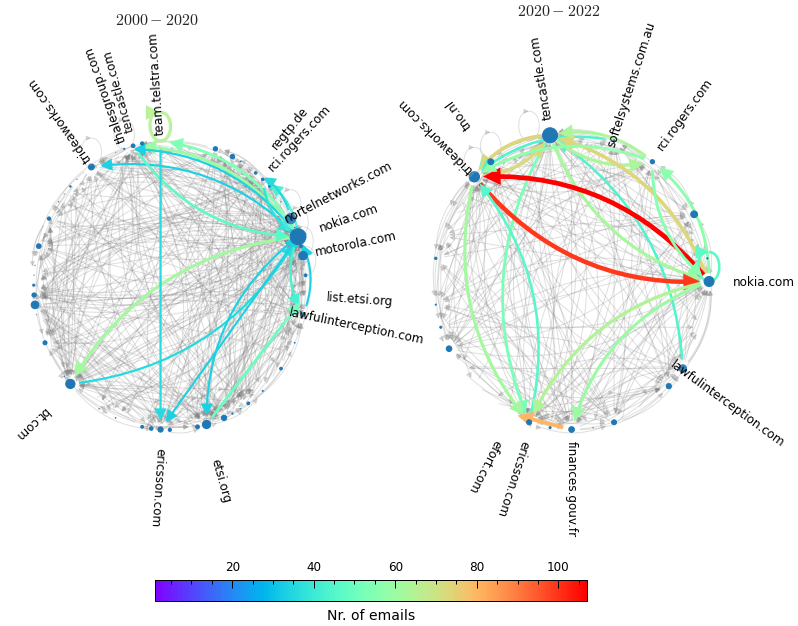

In [17]:
fig, axis = plt.subplots(
    1, 2,
    sharex=False, sharey=False,
    figsize=(30, 15),
    facecolor="w", edgecolor="w",
)
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)


for idx, dg in enumerate([dg_tset_1, dg_tset_2]):

    # prepare node positions and size
    node_size = graphs.node_size(dg)
    pos = nx.shell_layout(dg, nlist=[list(np.sort(list(dg.nodes())))])
    nx.draw_networkx_nodes(
        dg, pos,
        #node_color='b',
        node_size=node_size,
        #alpha=1/(node_size)**(1/4),
        ax=axis[idx],
    )

    # prepare edge size
    edge_with_map = graphs.edge_thickness(dg, exponent=1/3)
    # prepare edges style
    curved_edges = []
    for eidx, edge in enumerate(dg.edges()):
        if reversed(edge) in dg.edges():
            curved_edges.append(edge)
    straight_edges = list(set(dg.edges()) - set(curved_edges))
    # prepare edges color
    color_limit = np.sort(list(edge_with_map.values()))[-20]
    curved_edges_frg = [name for name in curved_edges if edge_with_map[name] >= color_limit]
    curved_edges_bkg = [name for name in curved_edges if edge_with_map[name] < color_limit]
    straight_edges_frg = [name for name in straight_edges if edge_with_map[name] >= color_limit]
    straight_edges_bkg = [name for name in straight_edges if edge_with_map[name] < color_limit]
    # prepare foreground graph
    edges_frg = curved_edges_frg + straight_edges_frg
    doms = np.unique([dom for doms in edges_frg for dom in doms])
    dg_frg = dg.subgraph(doms)
    pos_frg = {dom: pos[dom] for dom in doms}
    # draw background edges
    graphs.draw_edges(
        digraph=dg,
        pos=pos,
        edgelist=curved_edges_bkg,
        edge_color='grey',
        alpha=0.25,
        connectionstyle=f'arc3, rad = {0.25}',
        axis=axis[idx],
    )
    graphs.draw_edges(
        digraph=dg,
        pos=pos,
        edgelist=straight_edges_bkg,
        edge_color='grey',
        alpha=0.25,
        axis=axis[idx],
    )
    # draw foreground edges
    graphs.draw_edges(
        digraph=dg_frg,
        pos=pos_frg,
        edgelist=curved_edges_frg,
        widths=[edge_with_map[se] for se in curved_edges_frg],
        color_limits=edge_color_limits,
        edge_cmap=plt.cm.get_cmap('rainbow'),
        connectionstyle=f'arc3, rad = {0.25}',
        axis=axis[idx],
    )
    graphs.draw_edges(
        digraph=dg_frg,
        pos=pos_frg,
        edgelist=straight_edges_frg,
        widths=[edge_with_map[se] for se in straight_edges_frg],
        color_limits=edge_color_limits,
        edge_cmap=plt.cm.get_cmap('rainbow'),
        axis=axis[idx],
    )

    # write foreground labels
    description = nx.draw_networkx_labels(
        dg_frg, pos_frg,
        bbox={"facecolor":"w", "edgecolor":"w", "alpha":0.1},
        ax=axis[idx],
    )

    nodes_all = list(pos.keys())
    angle_dict = {}
    for i, node in zip(np.arange(len(nodes_all)), nodes_all):
        theta = 2. * np.pi * i / len(nodes_all) - np.pi
        angle_dict[node] = theta

    r = fig.canvas.get_renderer()
    trans = plt.gca().transData.inverted()
    for node, t in description.items():
        bb = t.get_window_extent(renderer=r)
        bbdata = bb.transformed(trans)
        radius = 1.4
        position = (
            radius * np.cos(angle_dict[node]),
            radius * np.sin(angle_dict[node]),
        )
        t.set_position(position)
        t.set_rotation(angle_dict[node]*360. / (2.*np.pi))
        t.set_clip_on(False)
    
    axis[idx].set_axis_off()

axis[0].text(
    -0.4, 1.8,
    r"$2000 - 2020$",
    fontsize=16,
)
axis[1].text(
    -0.4, 1.8,
    r"$2020 - 2022$",
    fontsize=16,
)

axis_colorbar = fig.add_axes([0.4, 0.2, 0.2, 0.02])
cbar = mpl.colorbar.ColorbarBase(
    axis_colorbar,
    orientation='horizontal', 
    cmap='rainbow',
    norm=mpl.colors.Normalize(np.min(edge_color_limits)**3, np.max(edge_color_limits)**3),
    label='This is a label',
    #ticks=[0, 3, 6, 9],
)
cbar.set_label(r'Nr. of emails', size=14, labelpad=7)
axis_colorbar.xaxis.set_label_position('bottom')
axis_colorbar.xaxis.set_ticks_position('top')

#"""
plt.savefig(
    f"{mlist_name}_{set_lable}_graph_domains.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

## Category graph

In [18]:
attribute_dict = {
    "node_name": list(df_seccat["email domain names"].values),
    "node_attribute": list(df_seccat["category"].values),
}
mlist_1.create_sender_receiver_digraph(node_attributes=attribute_dict)
mlist_2.create_sender_receiver_digraph(node_attributes=attribute_dict)

In [19]:
dg_tset_1 = graphs.contract_nodes_by_attribute(mlist_1.dg, node_attributes=attribute_dict)
dg_tset_2 = graphs.contract_nodes_by_attribute(mlist_2.dg, node_attributes=attribute_dict)

# dg_tset_1.remove_edge('Net Vendor', 'Consulting')
# dg_tset_1.remove_edge('Consulting', 'Net Vendor')
# dg_tset_2.remove_edge('Net Vendor', 'Consulting')
# dg_tset_2.remove_edge('Consulting', 'Net Vendor')

In [20]:
stakeholder_bc = nx.betweenness_centrality(dg_tset_2)
indices = np.argsort(list(stakeholder_bc.values()))[::-1]
stakeholder_bc = {list(stakeholder_bc.keys())[idx]: list(stakeholder_bc.values())[idx] for idx in indices[:]}
for key, value in stakeholder_bc.items():
    print(key, value)
print()

stakeholder_dc = nx.degree_centrality(dg_tset_2)
indices = np.argsort(list(stakeholder_dc.values()))[::-1]
stakeholder_dc = {list(stakeholder_dc.keys())[idx]: list(stakeholder_dc.values())[idx] for idx in indices[:]}
for key, value in stakeholder_dc.items():
    print(key, value)
print()

stakeholder_cc = nx.closeness_centrality(dg_tset_2)
indices = np.argsort(list(stakeholder_cc.values()))[::-1]
stakeholder_cc = {list(stakeholder_cc.keys())[idx]: list(stakeholder_cc.values())[idx] for idx in indices[:]}
for key, value in stakeholder_cc.items():
    print(key, value)
print()

stakeholders = np.unique([sth for edge in list(dg_tset_2.edges()) for sth in edge])
stakeholder_edges = {}
for sth in stakeholders:
    stakeholder_edges[sth] = len([edge for edge in list(dg_tset_2.edges()) if sth in edge[0]])
indices = np.argsort(list(stakeholder_edges.values()))[::-1]
stakeholder_edges = {list(stakeholder_edges.keys())[idx]: list(stakeholder_edges.values())[idx] for idx in indices[:]}
for key, value in stakeholder_edges.items():
    print(key, value)

Consulting 0.36929705215419506
Networking Equipment Vendor 0.16691609977324265
Unkown 0.05139455782312925
Regulatory Body 0.01829931972789116
Law Enforcement Agency 0.01612244897959184
Public Finances and
 Economic Policy 0.01060090702947846
Telecommunications Provider 0.010090702947845805
Research Institution 0.004251700680272109
Cybersecurity 0.0042176870748299325
Regional Standards Body 0.0011904761904761906
Internet Registry 0.0
Defence Agency 0.0
Chipmaker 0.0
Software Provider 0.0
Networking Service Provider 0.0
Technology Research and
 Development Company 0.0

Consulting 1.8
Networking Equipment Vendor 1.5333333333333332
Unkown 1.2
Law Enforcement Agency 1.1333333333333333
Telecommunications Provider 1.0666666666666667
Public Finances and
 Economic Policy 1.0
Cybersecurity 1.0
Research Institution 0.8666666666666667
Regulatory Body 0.6666666666666666
Regional Standards Body 0.6666666666666666
Networking Service Provider 0.4666666666666667
Software Provider 0.4
Technology Researc

In [21]:
_, weights_1 = zip(*nx.get_edge_attributes(dg_tset_1, "weight").items())
_, weights_2 = zip(*nx.get_edge_attributes(dg_tset_2, "weight").items())
edge_color_limits = [np.min(weights_1), np.min(weights_2), np.max(weights_1), np.max(weights_2)]
edge_color_limits = [np.min(edge_color_limits), np.max(edge_color_limits)]
edge_color_limits = np.power(np.array(list(edge_color_limits)), 1/3)

0 ==============================
1 ==============================


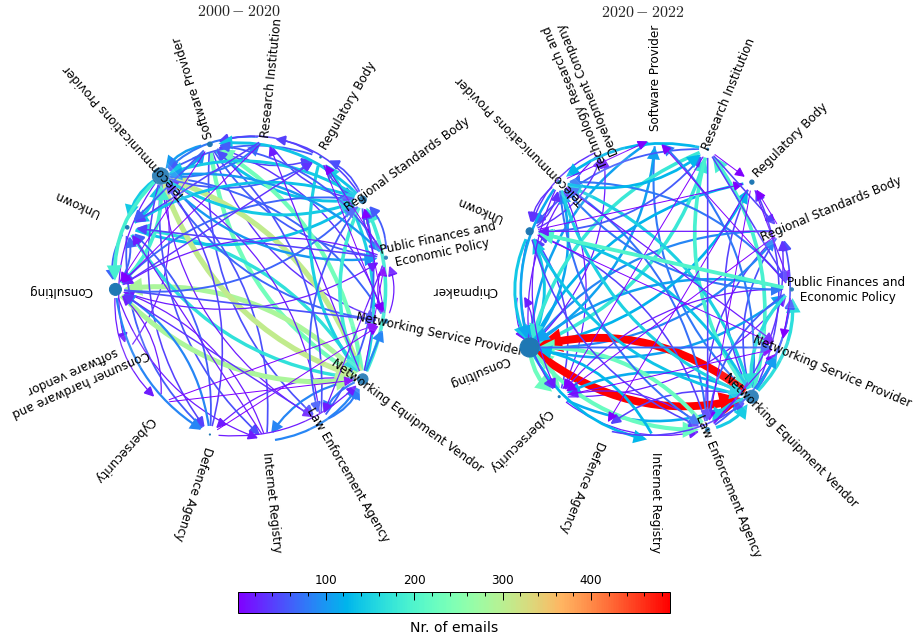

In [22]:
fig, axis = plt.subplots(
    1, 2,
    sharex=False, sharey=False,
    figsize=(30, 15),
    facecolor="w", edgecolor="w",
)
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)


for idx, dg in enumerate([dg_tset_1, dg_tset_2]):
    print(idx, "==============================")

    # prepare node positions and size
    node_size = graphs.node_size(dg)
    pos = nx.shell_layout(dg, nlist=[list(np.sort(list(dg.nodes())))])

    nx.draw_networkx_nodes(
        dg, pos,
        #node_color='b',
        node_size=node_size,
        #alpha=1/(node_size)**(1/4),
        ax=axis[idx],
    )

    # prepare edge sizes and colours
    edge_with_map = graphs.edge_thickness(dg, exponent=1/3)
    # draw edges
    curved_edges = []
    for eidx, edge in enumerate(dg.edges()):
        if reversed(edge) in dg.edges():
            curved_edges.append(edge)
    curved_edges = [
        edge
        for eidx, edge in enumerate(dg.edges())
        if reversed(edge) in dg.edges()
    ]
    straight_edges = list(set(dg.edges()) - set(curved_edges))
    arrow_widths = [edge_with_map[edg] for edg in curved_edges]
    graphs.draw_edges(
        digraph=dg,
        pos=pos,
        widths=arrow_widths,
        edgelist=curved_edges,
        color_limits=edge_color_limits,
        edge_cmap=plt.cm.get_cmap('rainbow'),
        axis=axis[idx],
        connectionstyle=f'arc3, rad = {0.25}',
    )
    arrow_widths = [edge_with_map[edg] for edg in straight_edges]
    graphs.draw_edges(
        digraph=dg,
        pos=pos,
        widths=arrow_widths,
        edgelist=straight_edges,
        color_limits=edge_color_limits,
        edge_cmap=plt.cm.get_cmap('rainbow'),
        axis=axis[idx],
    )

    # write foreground labels
    description = nx.draw_networkx_labels(
        dg, pos,
        bbox={"facecolor":"w", "edgecolor":"w", "alpha":0.1},
        ax=axis[idx],
    )

    nodes_all = list(pos.keys())
    angle_dict = {}
    for i, node in zip(np.arange(len(nodes_all)), nodes_all):
        theta = 2. * np.pi * i / len(nodes_all) - np.pi
        angle_dict[node] = theta

    r = fig.canvas.get_renderer()
    trans = plt.gca().transData.inverted()
    for node, t in description.items():
        bb = t.get_window_extent(renderer=r)
        bbdata = bb.transformed(trans)
        #radius = 1.25 + bbdata.width / 2.7
        radius = 1.4
        position = (
            radius * np.cos(angle_dict[node]),
            radius * np.sin(angle_dict[node]),
        )
        t.set_position(position)
        t.set_rotation(angle_dict[node]*360. / (2.*np.pi))
        t.set_clip_on(False)
    
    axis[idx].set_axis_off()

axis[0].text(
    -0.4, 1.8,
    r"$2000 - 2020$",
    fontsize=16,
)
axis[1].text(
    -0.4, 1.8,
    r"$2020 - 2022$",
    fontsize=16,
)

axis_colorbar = fig.add_axes([0.4, 0.2, 0.2, 0.02])
cbar = mpl.colorbar.ColorbarBase(
    axis_colorbar,
    orientation='horizontal', 
    cmap='rainbow',
    norm=mpl.colors.Normalize(np.min(edge_color_limits)**3, np.max(edge_color_limits)**3),
    label='This is a label',
    #ticks=[0, 3, 6, 9],
)
cbar.set_label(r'Nr. of emails', size=14, labelpad=7)
axis_colorbar.xaxis.set_label_position('bottom')
axis_colorbar.xaxis.set_ticks_position('top')

#"""
plt.savefig(
    f"{mlist_name}_{set_lable}_graph_category.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

## Nationality graph

In [23]:
attribute_dict = {
    "node_name": list(df_nation["email domain names"].values),
    "node_attribute": list(df_nation["nationality"].values),
}
mlist_1.create_sender_receiver_digraph(node_attributes=attribute_dict)
mlist_2.create_sender_receiver_digraph(node_attributes=attribute_dict)

In [24]:
dg_tset_1 = graphs.contract_nodes_by_attribute(mlist_1.dg, node_attributes=attribute_dict)
dg_tset_2 = graphs.contract_nodes_by_attribute(mlist_2.dg, node_attributes=attribute_dict)

In [25]:
# dg_tset_1.remove_edge('USA', 'FIN')
# dg_tset_1.remove_edge('FIN', 'USA')
# dg_tset_2.remove_edge('USA', 'FIN')
# dg_tset_2.remove_edge('FIN', 'USA')

In [26]:
stakeholder_bc = nx.betweenness_centrality(dg_tset_2)
indices = np.argsort(list(stakeholder_bc.values()))[::-1]
stakeholder_bc = {list(stakeholder_bc.keys())[idx]: list(stakeholder_bc.values())[idx] for idx in indices[:]}
for key, value in stakeholder_bc.items():
    print(key, value)
print()

stakeholder_dc = nx.degree_centrality(dg_tset_2)
indices = np.argsort(list(stakeholder_dc.values()))[::-1]
stakeholder_dc = {list(stakeholder_dc.keys())[idx]: list(stakeholder_dc.values())[idx] for idx in indices[:]}
for key, value in stakeholder_dc.items():
    print(key, value)
print()

stakeholder_cc = nx.closeness_centrality(dg_tset_2)
indices = np.argsort(list(stakeholder_cc.values()))[::-1]
stakeholder_cc = {list(stakeholder_cc.keys())[idx]: list(stakeholder_cc.values())[idx] for idx in indices[:]}
for key, value in stakeholder_cc.items():
    print(key, value)
print()

stakeholders = np.unique([sth for edge in list(dg_tset_2.edges()) for sth in edge])
stakeholder_edges = {}
for sth in stakeholders:
    stakeholder_edges[sth] = len([edge for edge in list(dg_tset_2.edges()) if sth in edge[0]])
indices = np.argsort(list(stakeholder_edges.values()))[::-1]
stakeholder_edges = {list(stakeholder_edges.keys())[idx]: list(stakeholder_edges.values())[idx] for idx in indices[:]}
for key, value in stakeholder_edges.items():
    print(key, value)

GBR 0.15554029304029304
DEU 0.1397501308215594
NLD 0.06350732600732602
Unkown 0.06043956043956045
USA 0.038873626373626374
FIN 0.02916666666666667
FRA 0.02247514390371533
SWE 0.012774725274725274
CAN 0.004709576138147567
CHE 0.004258241758241758
AUS 0.0014717425431711147
NOR 0.0
ITA 0.0
ESP 0.0
IND 0.0

GBR 1.7142857142857142
USA 1.5
FIN 1.5
NLD 1.5
FRA 1.357142857142857
SWE 1.357142857142857
Unkown 1.2857142857142856
DEU 1.2142857142857142
CAN 1.1428571428571428
AUS 1.0
CHE 0.9285714285714285
ESP 0.3571428571428571
NOR 0.2857142857142857
IND 0.2857142857142857
ITA 0.14285714285714285

GBR 0.8047619047619048
USA 0.7544642857142857
FIN 0.7544642857142857
NLD 0.7544642857142857
SWE 0.7100840336134454
DEU 0.7100840336134454
FRA 0.6706349206349207
Unkown 0.6706349206349207
CAN 0.6353383458646616
AUS 0.6353383458646616
CHE 0.6035714285714286
ESP 0.5833333333333334
NOR 0.5029761904761905
IND 0.4828571428571429
ITA 0.416256157635468

GBR 13
USA 11
NLD 11
FRA 11
FIN 11
SWE 10
Unkown 9
CAN 9
DE

In [27]:
_, weights_1 = zip(*nx.get_edge_attributes(dg_tset_1, "weight").items())
_, weights_2 = zip(*nx.get_edge_attributes(dg_tset_2, "weight").items())
edge_color_limits = [np.min(weights_1), np.min(weights_2), np.max(weights_1), np.max(weights_2)]
edge_color_limits = [np.min(edge_color_limits), np.max(edge_color_limits)]
edge_color_limits = np.power(np.array(list(edge_color_limits)), 1/3)

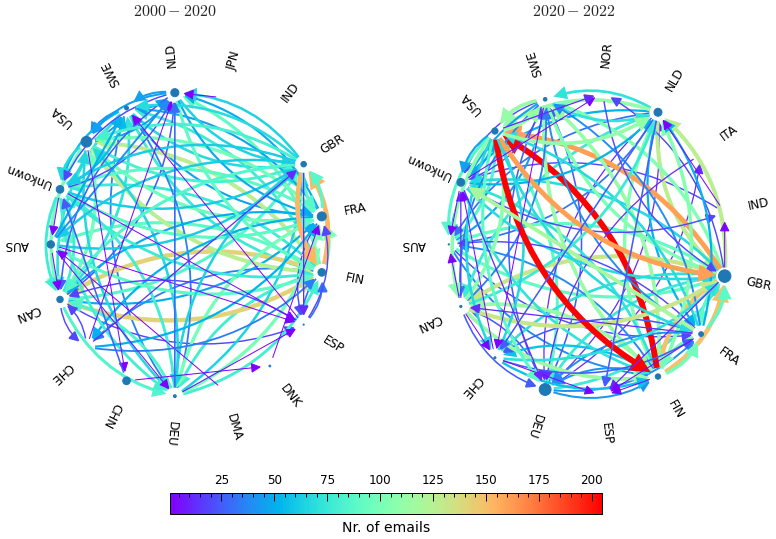

In [31]:
fig, axis = plt.subplots(
    1, 2,
    sharex=False, sharey=False,
    figsize=(30, 15),
    facecolor="w", edgecolor="w",
)
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)


for idx, dg in enumerate([dg_tset_1, dg_tset_2]):

    # prepare node positions and size
    node_size = graphs.node_size(dg)
    pos = nx.shell_layout(dg, nlist=[list(np.sort(list(dg.nodes())))])

    nx.draw_networkx_nodes(
        dg, pos,
        #node_color='b',
        node_size=node_size,
        #alpha=1/(node_size)**(1/4),
        ax=axis[idx],
    )

    # prepare edge sizes and colours
    edge_with_map = graphs.edge_thickness(dg, exponent=1/3)
    # draw edges
    curved_edges = [
        edge
        for eidx, edge in enumerate(dg.edges())
        if reversed(edge) in dg.edges()
    ]
    straight_edges = list(set(dg.edges()) - set(curved_edges))
    arrow_widths = [edge_with_map[edg] for edg in curved_edges]
    graphs.draw_edges(
        digraph=dg,
        pos=pos,
        widths=arrow_widths,
        edgelist=curved_edges,
        color_limits=edge_color_limits,
        edge_cmap=plt.cm.get_cmap('rainbow'),
        axis=axis[idx],
        connectionstyle=f'arc3, rad = {0.25}',
    )
    arrow_widths = [edge_with_map[edg] for edg in straight_edges]
    graphs.draw_edges(
        digraph=dg,
        pos=pos,
        widths=arrow_widths,
        edgelist=straight_edges,
        color_limits=edge_color_limits,
        edge_cmap=plt.cm.get_cmap('rainbow'),
        axis=axis[idx],
    )

    # write foreground labels
    description = nx.draw_networkx_labels(
        dg, pos,
        bbox={"facecolor":"w", "edgecolor":"w", "alpha":0.1},
        ax=axis[idx],
    )

    nodes_all = list(pos.keys())
    angle_dict = {}
    for i, node in zip(np.arange(len(nodes_all)), nodes_all):
        theta = 2. * np.pi * i / len(nodes_all) - np.pi
        angle_dict[node] = theta

    r = fig.canvas.get_renderer()
    trans = plt.gca().transData.inverted()
    for node, t in description.items():
        bb = t.get_window_extent(renderer=r)
        bbdata = bb.transformed(trans)
        radius = 1.25
        position = (
            radius * np.cos(angle_dict[node]),
            radius * np.sin(angle_dict[node]),
        )
        t.set_position(position)
        t.set_rotation(angle_dict[node]*360. / (2.*np.pi))
        t.set_clip_on(False)
    
    axis[idx].set_axis_off()

axis[0].text(
    -0.4, 1.5,
    r"$2000 - 2020$",
    fontsize=16,
)
axis[1].text(
    -0.4, 1.5,
    r"$2020 - 2022$",
    fontsize=16,
)

axis_colorbar = fig.add_axes([0.4, 0.25, 0.2, 0.02])
cbar = mpl.colorbar.ColorbarBase(
    axis_colorbar,
    orientation='horizontal', 
    cmap='rainbow',
    norm=mpl.colors.Normalize(np.min(edge_color_limits)**3, np.max(edge_color_limits)**3),
    label='This is a label',
    #ticks=[0, 3, 6, 9],
)
cbar.set_label(r'Nr. of emails', size=14, labelpad=7)
axis_colorbar.xaxis.set_label_position('bottom')
axis_colorbar.xaxis.set_ticks_position('top')

#"""
plt.savefig(
    f"{mlist_name}_{set_lable}_graph_nation.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""